<hr>

### <font color=cornflowerblue>**準備訓練集説明**</font>

以下為本實驗模糊訓練集影像的處理方式。執行流程如下：
- 將清晰之影像切成小圖（patch）。

- 逐一進行高斯模糊化（gaussian blur）。

- 縮小再放大 $\frac{1}{3}$ 進行解析度損失（downsampling–upsampling）。

- 分別儲存清晰與模糊影像於：
    - inputs/T91_blurred_patches。
    - inputs/T91_sharp_patches。

### <font color=cornflowerblue>**目錄**</font>
1. 套件宣告

1. 常數宣告

1. 副程式宣告

1. 執行圖像裁切

1. 分別顯示原圖、裁切後清晰與模糊小圖

<hr>

### <font color=cornflowerblue>**套件宣告**</font>

In [ ]:
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import patchify
import numpy as np
import matplotlib.gridspec as gridspec
import glob as glob
import os
import cv2
import shutil

<hr>

### <font color=cornflowerblue>**常數宣告**</font>

- 主目錄路徑（DIR_PATH）: '../'

    - 指定圖片或其他資料的主目錄路徑，'../' 表示進入程式碼所處文件夾的上一個文件夾。

- 是否顯示圖片切片預覽（SHOW_PATCHES）: False

    - 控制是否使用 matplotlib 顯示切割後的小圖像（patches）以利人工檢查。

- 切片步距（STRIDE）: 14

    - 控制圖片在進行切片（patchify）時的滑動步長，影響 patch 的數量與重疊程度。

- 圖片大小（SIZE）: $35 \times 35$。

    - 每一個 patch 的寬與高（大小為 35x35），將原圖分割成這個大小的小圖。

- 高斯核大小（GAUSSIAN_KERNEL_SIZE_PATCH）: (7, 7)。

    - 對 patch 進行高斯模糊時所使用的濾波器大小。較大值會產生較強的模糊效果。

- 高斯核標準差（SIGMAX）: 0。

    - 控制高斯模糊強度。若設為 0，OpenCV 會自動根據 kernel size 計算標準差。

In [2]:
DIR_PATH = '../'
SHOW_PATCHES = False
STRIDE = 14 # Stride for the patches.
SIZE = 35 # Size of the patches.
GAUSSIAN_KERNEL_SIZE_PATCH = (7, 7) # Kernel size for Gaussian blur.
SIGMAX = 0 # Sigma for Gaussian blur. 0 means it is calculated from the kernel size.


<hr>

### <font color=cornflowerblue>**副程式宣告**</font>

包含兩種函數：

- show_patches(patches) : 畫出切片後的小圖。

- create_patches(input_paths, out_sharp_path, out_blur_path) : 將圖片做切分，並進行模糊化，分別建立清晰與模糊圖的儲存文件夾將圖片儲存在里面。

In [3]:
def show_patches(patches):
    """
    Function to plot the patches.
    """
    plt.figure(figsize=(patches.shape[0], patches.shape[1]))
    gs = gridspec.GridSpec(patches.shape[0], patches.shape[1])
    gs.update(wspace=0.01, hspace=0.02)
    counter = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            ax = plt.subplot(gs[counter])
            plt.imshow(patches[i, j, 0, :, :, :])
            plt.axis('off')
            counter += 1
    plt.show()

def create_patches(input_paths, out_sharp_path, out_blur_path):
    '''
    Function to create patches from the images in the input paths.
    The patches are saved in the output paths.'''
    
    os.makedirs(out_sharp_path, exist_ok=True)
    os.makedirs(out_blur_path, exist_ok=True)
    all_paths = []

    for input_path in input_paths:
        all_paths.extend(glob.glob(f"{input_path}/*"))
    print(f"Creating patches for {len(all_paths)} images")

    for image_path in tqdm(all_paths, total=len(all_paths)):
        image = Image.open(image_path)
        image_name = image_path.split(os.path.sep)[-1].split('.')[0]
        
        patches = patchify.patchify(np.array(image), (SIZE, SIZE, 3), STRIDE)
        if SHOW_PATCHES:
            show_patches(patches)

        # print(patches.shape)
        counter = 0
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                counter += 1
                patch = patches[i, j, 0, :, :, :]
                patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
                cv2.imwrite(
                    f"{out_sharp_path}/{image_name}_{counter}.png",
                    patch
                )
                # Step 1: apply Gaussian blur
                blur = cv2.GaussianBlur(patch, GAUSSIAN_KERNEL_SIZE_PATCH, sigmaX=SIGMAX)
                # Step 2: resize to 1/3 size
                height, width = blur.shape[:2]
                small = cv2.resize(blur, (width // 3, height // 3), interpolation=cv2.INTER_AREA)
                # Step 3: resize back to original size
                restored = cv2.resize(small, (width, height), interpolation=cv2.INTER_LINEAR)

                cv2.imwrite(
                    f"{out_blur_path}/{image_name}_{counter}.png",
                    restored
                )


<hr>

### <font color=cornflowerblue>**執行圖像裁切**</font>

- 設定清晰與模糊小圖的儲存位置。

- 執行 create_patches 函數做裁切。

In [ ]:
input_paths =  [f"{DIR_PATH}inputs/T91/"]
outputs_sharp_path = DIR_PATH + "inputs/T91_sharp_patches"
outputs_blur_path = DIR_PATH + "inputs/T91_blurred_patches"

# Check and remove if folders exist
if os.path.exists(outputs_sharp_path):
    shutil.rmtree(outputs_sharp_path)
    print(f"Removed existing folder: {outputs_sharp_path}")

if os.path.exists(outputs_blur_path):
    shutil.rmtree(outputs_blur_path)
    print(f"Removed existing folder: {outputs_blur_path}")

# 執行
create_patches(input_paths, outputs_sharp_path, outputs_blur_path)
print('DONE')

Creating patches for 91 images


100%|██████████| 91/91 [00:37<00:00,  2.44it/s]

DONE


<hr>

### <font color=cornflowerblue>**分別顯示原圖、裁切後清晰與模糊小圖**</font>
以下展示 T91 資料集中第一張圖片的原圖，以及經 patchify 裁切後所得到的清晰圖與模糊圖。

<font color=red>**特別說明：**</font>由於當 STRIDE < SIZE 時，patchify 在裁切時會讓每個小圖（patch）之間產生重疊，因此若要精確重建出原圖，必須將所有重疊區域的像素進行「滑動視窗平均」(sliding window reconstruction)：也就是對每個像素，取所有被 patch 覆蓋到的值再平均。這種方式才能最大程度還原出接近原圖的畫面。因此，下方的重建圖其實並非將每個 patch 單純拼接而成的「原圖模樣」，而是經過滑動視窗平均後的近似結果。不過，因本步驟主要目的在於比較清晰圖與模糊圖在視覺上的差異，這種做法對觀察重點並無影響。

此外，重建後的影像右側（或下側）會出現黑色區塊，這是因為 patchify 僅會裁切出能完整涵蓋 patch 大小的區域，導致最右側和最下方的像素，若未被任何 patch 覆蓋，就會在重建時顯示為黑色。

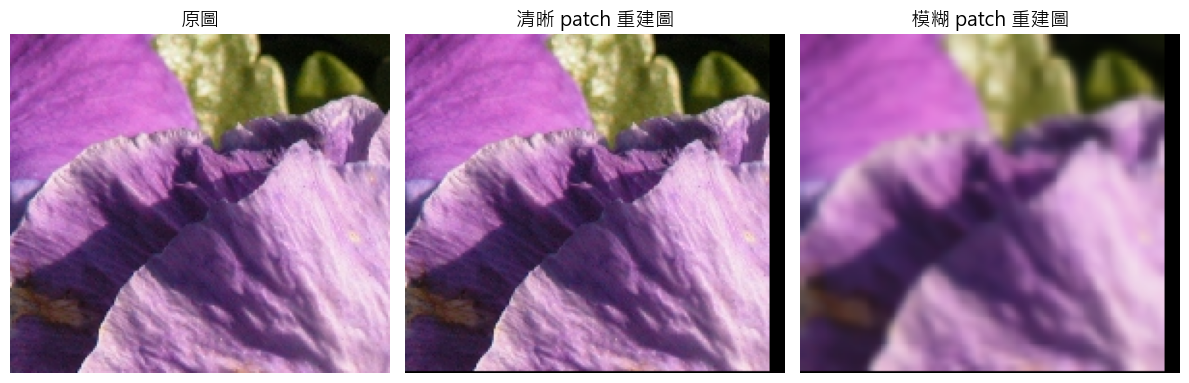

In [ ]:
def load_sorted_patches(patch_dir, base_name):
    files = [f for f in os.listdir(patch_dir) if f.startswith(base_name)]
    files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    patches = []
    for f in files:
        patch = cv2.imread(os.path.join(patch_dir, f))
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        patches.append(patch)
    return np.array(patches)

def reconstruct_from_patches_average(patches, image_shape, patch_size, stride):
    H, W, C = image_shape
    recon = np.zeros((H, W, C), dtype=np.float32)
    weight = np.zeros((H, W, C), dtype=np.float32)

    idx = 0
    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = patches[patch_idx]
            recon[i:i+patch_size, j:j+patch_size] += patch
            weight[i:i+patch_size, j:j+patch_size] += 1.0
            patch_idx += 1
    recon /= np.maximum(weight, 1)
    recon = np.clip(recon, 0, 255).astype(np.uint8)
    return recon

# 中文字型設置（Windows）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 設定參數
original_image_path = DIR_PATH + "inputs/T91/t1.png"
sharp_dir = DIR_PATH + "inputs/T91_sharp_patches"
blur_dir = DIR_PATH + "inputs/T91_blurred_patches"
base_name = 't1_'

# 讀 patch
sharp_patches = load_sorted_patches(sharp_dir, base_name)
blur_patches = load_sorted_patches(blur_dir, base_name)

# 原圖資訊
im = Image.open(original_image_path)
W, H = im.size
image_shape = (H, W, 3)
original_img = np.array(im)

# 重建影像
sharp_recon = reconstruct_from_patches_average(sharp_patches, image_shape, SIZE, STRIDE)
blur_recon = reconstruct_from_patches_average(blur_patches, image_shape, SIZE, STRIDE)

# 畫三圖
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(original_img)
axs[0].set_title("原圖", fontsize = 14)
axs[0].axis('off')

axs[1].imshow(sharp_recon)
axs[1].set_title("清晰 patch 重建圖", fontsize = 14)
axs[1].axis('off')

axs[2].imshow(blur_recon)
axs[2].set_title("模糊 patch 重建圖", fontsize = 14)
axs[2].axis('off')

plt.tight_layout()
plt.show()


#### **討論：**
- 圖片已成功完成切片與雙重模糊處理，產生出清晰與模糊的對照影像。

- 由圖可見，原圖與模糊圖在視覺上呈現明顯差異，顯示模糊化處理效果良好。這樣的資料集有助於後續模型學習影像去模糊任務，能有效作為訓練集使用。

<hr>